In [33]:
from Bio import SeqIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tools

np.random.seed(42)
import yaml
import scipy.stats as stats
import re

In [34]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import sklearn

In [35]:
sequence_data = 'chromosome1.fasta'
with open(sequence_data) as file:
    fasta_sequences = SeqIO.parse(file, 'fasta')
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)

In [62]:
data = pd.read_csv('data/start_features.csv')
cds_location_data = pd.read_csv('data/start_cds_location.csv')
seq_before_cds_location = np.array(cds_location_data)
data.shape

(4956, 85)

In [63]:
Y = data['target']
X = data.drop(['target'], axis=1)

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y, shuffle=True)

test_indices = X_test.index[X_test.index<seq_before_cds_location.shape[0]].values
train_indices = X_train.index[X_train.index<seq_before_cds_location.shape[0]].values

X_train, X_test, LDA, x_scaler = tools.apply_pca(X_train.values, X_test.values, Y_train.values)

In [65]:
model = SVC(C = 100, gamma = 'scale', kernel = 'linear', tol = 0.0386488981125862) 
#model = RandomForestClassifier(n_estimators=400, criterion='log_loss', max_depth=3)
#model = GradientBoostingClassifier(n_estimators=200, loss='log_loss', max_depth=2)
#model = GaussianNB()

In [66]:
#model.classes_ = ['start', 'zero', 'end']

f1 score:0.574


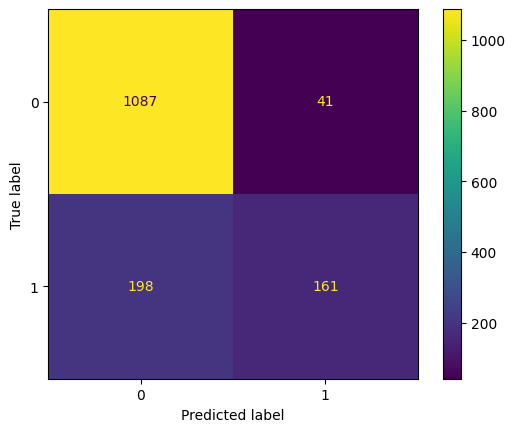

In [68]:
model.fit(X_train, Y_train)
prediction = model.predict(X_test) 
cm = confusion_matrix(prediction, Y_test)

print(f'f1 score:{f1_score(Y_test, prediction, average="binary"):.3f}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm.T, display_labels=model.classes_)
disp.plot()

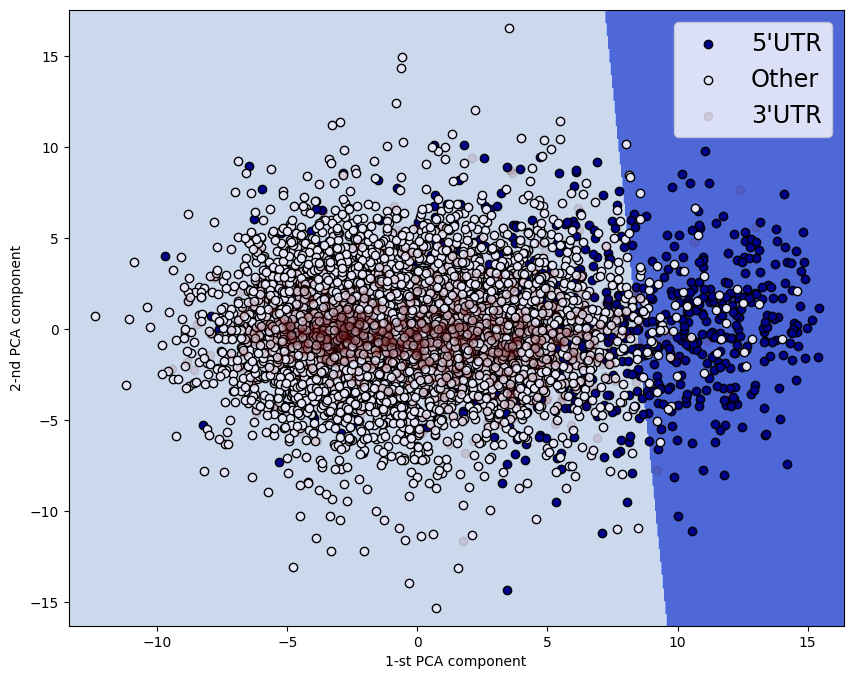

In [55]:
n_classes = 3
plt.figure(figsize=(10, 8))
target_names = ["5'UTR", 'Other', "3'UTR"]
plot_colors = ['darkblue', 'lavender', 'maroon']
alphas = [1.0, 1.0, 0.1]
plot_step = 0.05

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

preds = model.predict(
    np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1))

preds_class = preds.reshape(xx.shape)
preds_class[-1, -1] = 2
plt.contourf(xx, yy, preds_class, cmap='coolwarm')

for i, color in zip(range(n_classes), plot_colors):
    
    indexes = np.where(Y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=target_names[i],
                linewidths=1,
                edgecolors='black',
                alpha=alphas[i])
    plt.legend(loc='upper right', fontsize='xx-large')
    
    
plt.xlabel('1-st PCA component')
plt.ylabel('2-nd PCA component')
plt.savefig('figures/6.png', 
                     dpi=200, 
                     bbox_inches='tight', 
                     pad_inches = 0.1, 
                     transparent=True)

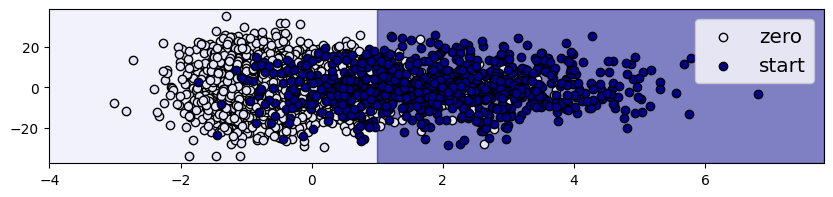

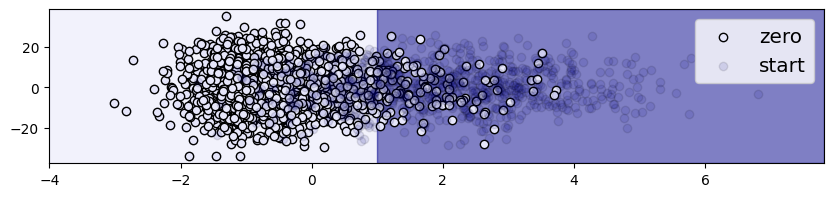

In [387]:
n_classes = 2
plt.figure(figsize=(10, 2))

alphas = [1.0, 1.0]
target_names =  ['zero', 'start']
plot_colors = ['lavender', 'darkblue']
plot_step = 0.1

x_min, x_max = X_train.min() - 1, X_train.max() + 1
xx =  np.arange(x_min, x_max, plot_step)

preds = model.predict(xx.reshape(-1, 1))
res = list(preds)

preds_class = preds.reshape(xx.shape)


vert_values = []
for i in range(n_classes):
    indexes = np.where(Y_train == i)
    vert_values.append(np.random.normal(0, 10, size=X_train[indexes].shape))


plt.xlim(x_min, x_max)
plt.axvspan(x_min, xx[res.index(1)], alpha=0.5, color='lavender')
plt.axvspan(xx[res.index(1)], x_max, alpha=0.5, color='darkblue')

for i, color in zip(range(n_classes), plot_colors):
    
    indexes = np.where(Y_train == i)
    plt.scatter(X_train[indexes], 
                vert_values[i], 
                c=color, 
                label=target_names[i],
                linewidths=1,
                edgecolors='black',
                alpha=alphas[i])
    plt.legend(fontsize='x-large')
plt.show()

    
alphas = [1.0, 0.1]

plt.figure(figsize=(10, 2))
plt.xlim(x_min, x_max)
plt.axvspan(x_min, xx[res.index(1)], alpha=0.5, color='lavender')
plt.axvspan(xx[res.index(1)], x_max, alpha=0.5, color='darkblue')

for i, color in zip(range(n_classes), plot_colors):
    
    indexes = np.where(Y_train == i)
    plt.scatter(X_train[indexes], 
                vert_values[i], 
                c=color, 
                label=target_names[i],
                linewidths=1,
                edgecolors='black',
                alpha=alphas[i])
    plt.legend(fontsize='x-large')   

plt.show()

In [349]:
start_codon_location = pd.read_csv('start_codon_location.csv').values.squeeze()

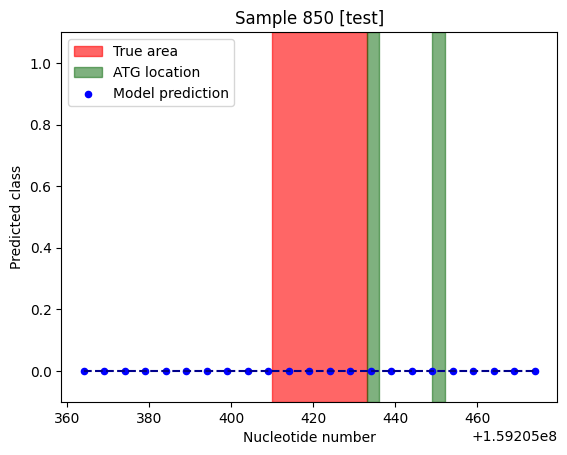

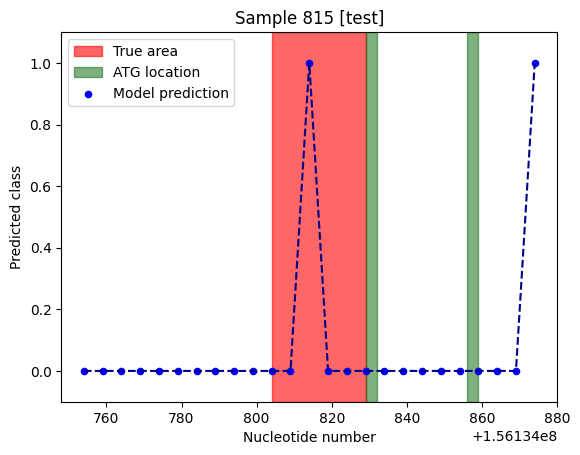

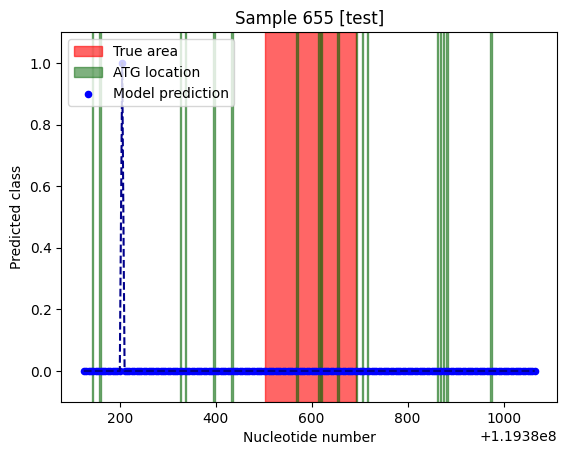

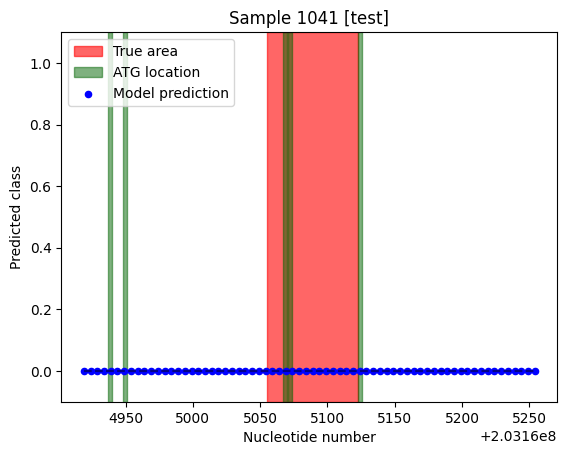

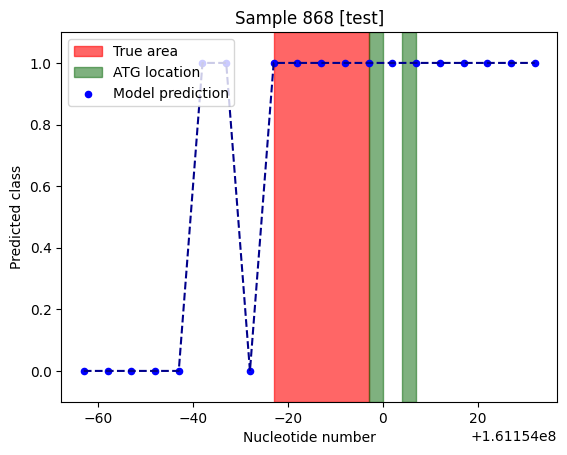

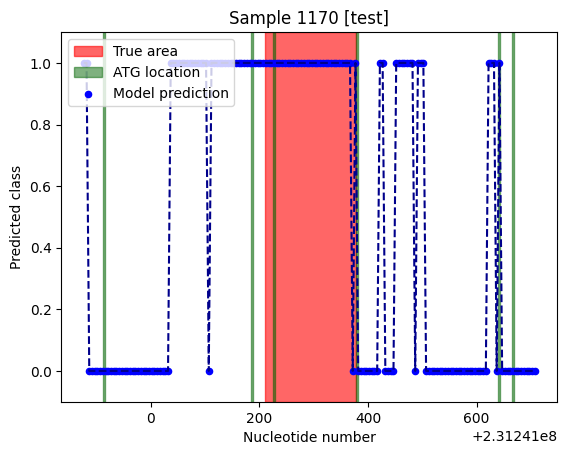

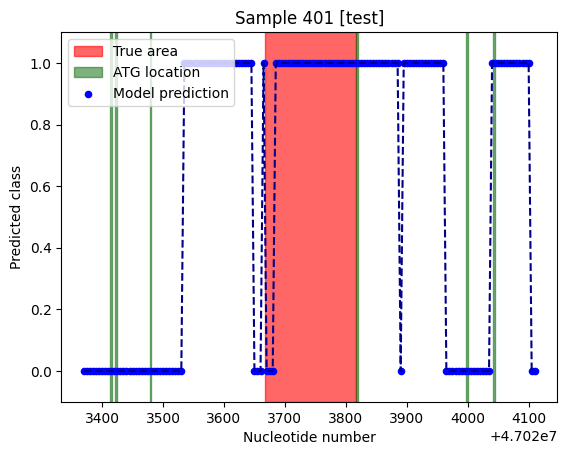

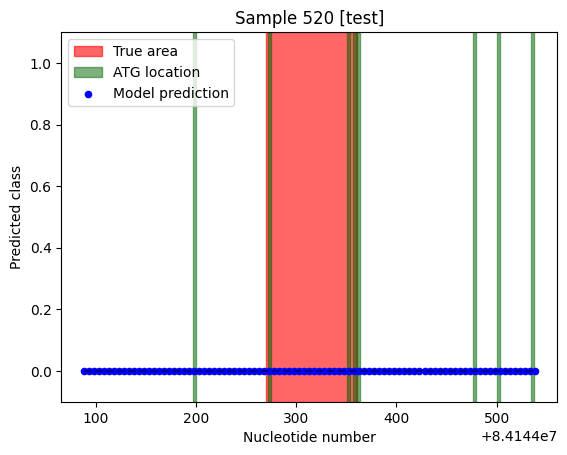

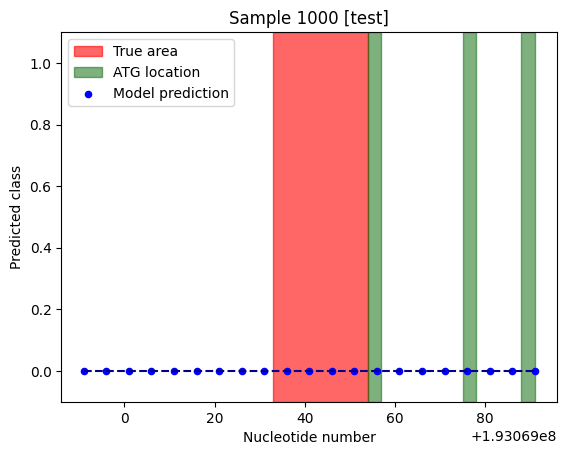

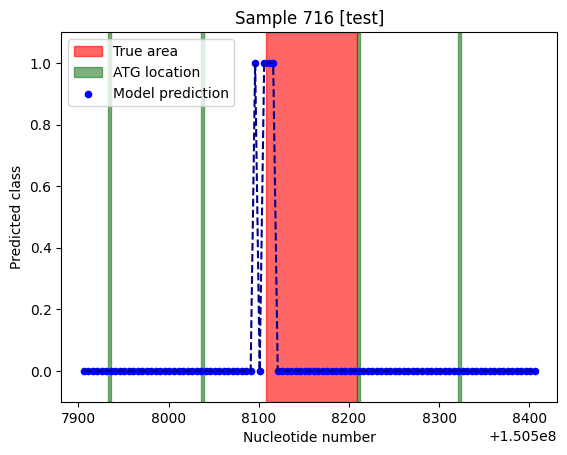

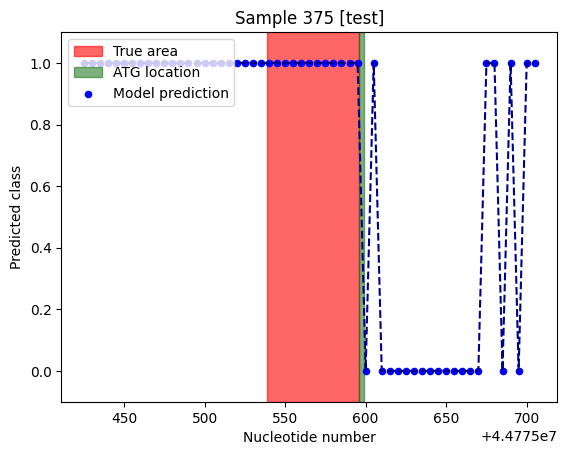

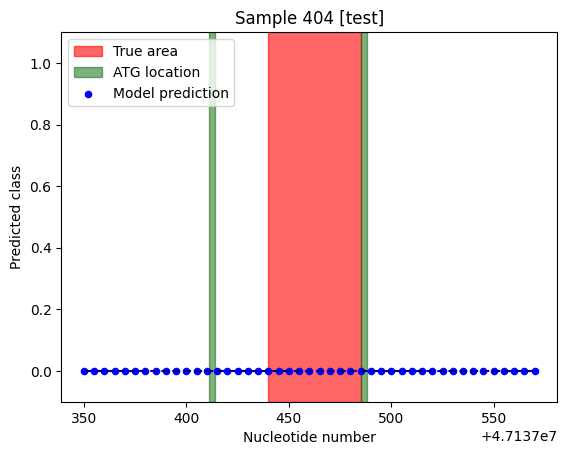

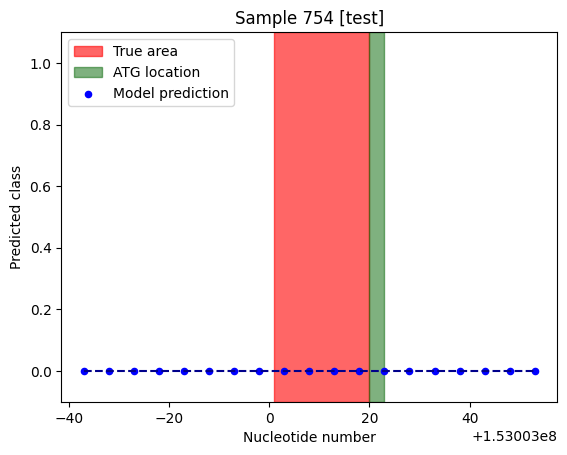

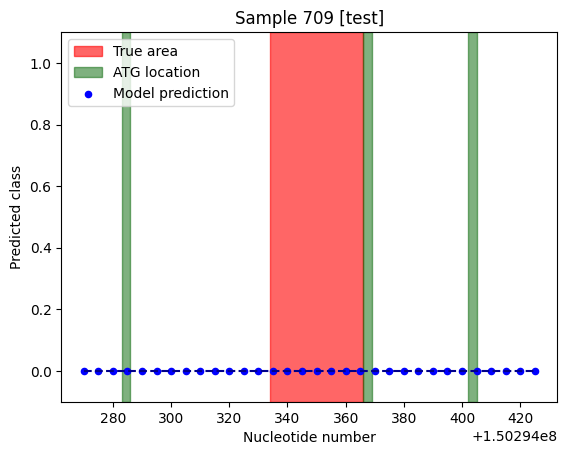

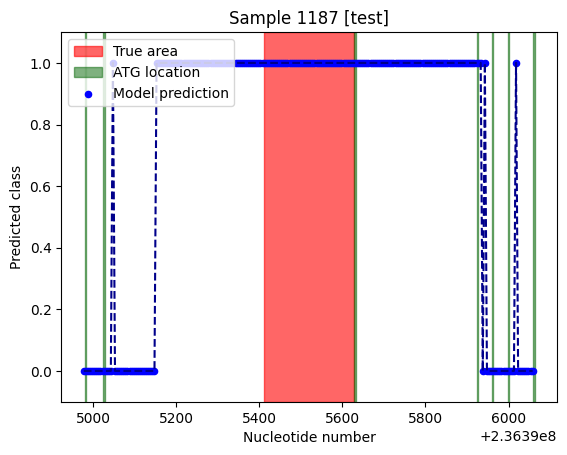

In [361]:
windows = [36, 80, 160]
step = 5

group = 'train'

if group == 'train':
    indices = train_indices
elif group == 'test':
    indices = test_indices
    
for graph in list(np.random.choice(indices, size=3)):

    fig, ax = plt.subplots()
    i, j = seq_before_cds_location[graph]
    length = j-i
    ax.axvspan(i, j, alpha=0.6, color='red', label='True area')
    scope = np.arange(i-2*length, j+2*length, step).astype('int')
    
    res = []
    for w in windows:
        for point in scope:
            scores = tools.calculate_kmer_features(sequence[point-w//2: point+w//2], tools.signs)['Entropy']
            scores = scores.values.reshape(1, -1)
            scores = x_scaler.transform(scores)
            scores = LDA.transform(scores)
            res.append(model.predict(scores)[0])
            #res.append(model.predict_proba(scores)[0][1])
        
                       
    res = np.array(res).reshape(len(windows), -1).mean(axis=0)
    res = np.where(res>0.5, 1, 0)
    
    plt.title(f'Sample {graph} [{group}]')
    plt.ylim(-0.1, 1.1)

    local_start_codon = [c for c in start_codon_location if ((c>=i-2*length) and (c<=j+2*length))]
    for i , codon in enumerate(local_start_codon):
        if i == 0:
            ax.axvspan(codon, codon+3, alpha=0.5, color='darkgreen', label='ATG location')
        else:
            ax.axvspan(codon, codon+3, alpha=0.5, color='darkgreen')

    plt.plot(scope, res, color='darkblue', linestyle='--')
    plt.scatter(scope, res, color='blue', s=20, label='Model prediction')
    plt.xlabel('Nucleotide number')
    plt.ylabel('Predicted class')
    plt.legend(loc='upper left')
    
    plt.savefig(f'figures/{graph}.png', 
                     dpi=200, 
                     bbox_inches='tight', 
                     pad_inches = 0.1, 
                     transparent=True)
    
    plt.show()